## Viasualize historial shortage 

In [173]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta

In [174]:
# Load updated shorage database
df = pd.read_csv("Shortage data/shortage_final.csv")

# converting headers in lowercase
df.columns = df.columns.str.lower()

# replacing spaces for "_" in headers
df.columns = df.columns.str.replace(' ', '_')

# Removing NaN actual_start_date and actual_end_date, considering as an incomplete record
df=df.dropna(subset=['actual_start_date','actual_end_date'] )

# Removing Actuals before 2017
df = df.loc[(df['actual_start_date'] >= '2017-01-01')]
# Removing outliers before 2010 for End_date
df = df.loc[(df['actual_end_date'] >= '2010-01-01')]

# Removing duplicates ID Reports
df=df.drop_duplicates("report_id", keep=False)

# Removing Avoided shortages (outliers for our analysis)
df = df[df['shortage_status']!="Avoided shortage"]

df.tail()

,report_id,drug_identification_number,report_type,brand_name,company_name,common_or_proper_name,ingredients,strength(s),packaging_size,route_of_administration,...,atc_code,atc_description,anticipated_start_date,actual_start_date,estimated_end_date,actual_end_date,reason,date_created,date_updated,tier_3
17163,21685,2340445.0,Shortage,ZYCLARA,VALEANT CANADA LP/VALEANT CANADA S.E.C.,ZYCLARA,IMIQUIMOD,3.75%,na,TOPICAL,...,D06BB,CHEMOTHERAPEUTICS FOR TOPICAL USE,NaN,2017-09-08,2017-09-22,2017-09-22,Other (Please describe in comments),2017-09-08,2017-09-25,No
17164,52702,2340445.0,Shortage,ZYCLARA,VALEANT CANADA LP/VALEANT CANADA S.E.C.,ZYCLARA,IMIQUIMOD,3.75%,7.5g pump,TOPICAL,...,D06BB,CHEMOTHERAPEUTICS FOR TOPICAL USE,NaN,2019-04-01,NaN,2019-07-12,Other (Please describe in comments),2018-06-20,2019-07-13,No
17165,18241,2257270.0,Shortage,ZYMAR,ALLERGAN INC,ZYMAR 1mL,GATIFLOXACIN,0.3%,1 mL,OPHTHALMIC,...,S01AE,ANTIINFECTIVES,2017-08-03,2017-08-03,2017-09-18,2017-10-06,Disruption of the manufacture of the drug.,2017-08-03,2017-10-13,No
17166,33440,2257270.0,Shortage,ZYMAR,ALLERGAN INC,ZYMAR 1mL,GATIFLOXACIN,0.3%,5mL,OPHTHALMIC,...,S01AE,ANTIINFECTIVES,2019-09-16,2019-09-16,2019-09-20,2019-09-18,Disruption of the manufacture of the drug.,2017-12-18,2019-09-19,No
17167,54338,2243686.0,Shortage,ZYVOXAM,PFIZER CANADA INC,Zyvoxam,LINEZOLID,3G,1x240ml Btl,ORAL,...,J01XX,OTHER ANTIBACTERIALS,NaN,2018-08-21,NaN,2018-10-23,Disruption of the manufacture of the drug.,2018-07-04,2018-10-24,No


In [175]:
# Loading selected drug
df2 = df[df.common_or_proper_name=='AMOXICILLIN']

In [176]:
df2.columns

Index(['report_id', 'drug_identification_number', 'report_type', 'brand_name',
       'company_name', 'common_or_proper_name', 'ingredients', 'strength(s)',
       'packaging_size', 'route_of_administration', 'shortage_status',
       'dosage_form(s)', 'atc_code', 'atc_description',
       'anticipated_start_date', 'actual_start_date', 'estimated_end_date',
       'actual_end_date', 'reason', 'date_created', 'date_updated', 'tier_3'],
      dtype='object')

<AxesSubplot:xlabel='reason', ylabel='count'>

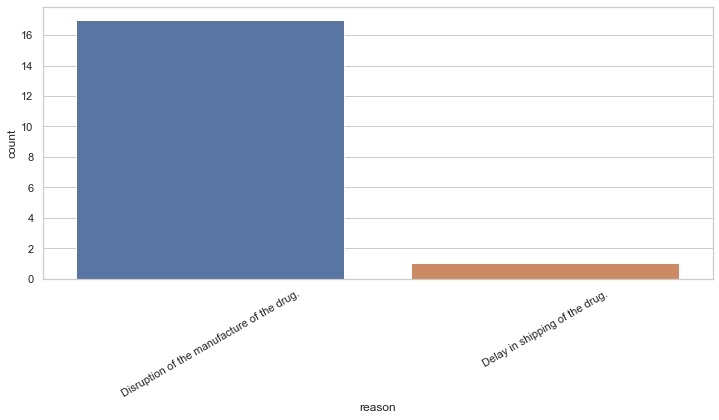

In [177]:
sns.set(rc={'figure.figsize':(12,5)})
sns.set_theme(style="whitegrid")

plt.xticks(rotation=30)
sns.countplot(x=df2['reason'])

In [178]:
# filtering columns
col_list = ['actual_start_date', 'actual_end_date']
df2 = df2[col_list]

In [179]:
# loading timeseries from 2017-01-01, getting number of days
today = datetime.date.today()
start = datetime.date(2017,1,1)
diff = (today - start).days
diff

2296

In [180]:
# ---- Create day index
temp_day = datetime.date(2017,1,1)
index = [(temp_day + datetime.timedelta(days=d)) for d in range(diff)]

In [181]:
# ---- Create empty result df
# initialize df, set days as datetime in index
d = pd.DataFrame(np.zeros((diff,1)),
                 index=pd.to_datetime(index),
                 columns=['shortage_day'])

# ---- Iterate over df to fill d (final df)
for i, row in df2.iterrows():

    # 1 if some visitor in df.start, df.end
    d.loc[row.actual_start_date:row.actual_end_date,'shortage_day'] = 1




In [182]:
# print(d.loc['2017-03-05':'2017-03-20'])

In [183]:
d=d.reset_index()
d['index'] = d['index'].astype('datetime64[D]')

In [184]:
d.dtypes

index           datetime64[ns]
shortage_day           float64
dtype: object

In [185]:
# Get Date into months and years
d['Date'] = d.index
d['Year'] = d['index'].dt.year
d['Month'] = d['index'].dt.month

In [186]:
# Plot historical
import plotly.express as px

fig = px.area(d, x='index', y="shortage_day",width=900, height=220)
fig.update_yaxes(title='Shortage Yes/No', visible=True, showticklabels=False,title_font_family="Arial Narrow")

fig.show()


In [187]:
# Plot Scatter plot by years
fig = px.area(d, x='Month', y="shortage_day", facet_col="Year", facet_col_wrap=1,
              width=600, height=1000)
fig.update_yaxes(title='Shortage Yes/No', visible=False, showticklabels=False)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_xaxes(title_font_family="Arial Narrow")
fig.update_layout(
   xaxis = dict(
      tickmode = 'linear',
      tick0 = 0,
      dtick = 1
   )
)
fig.show()

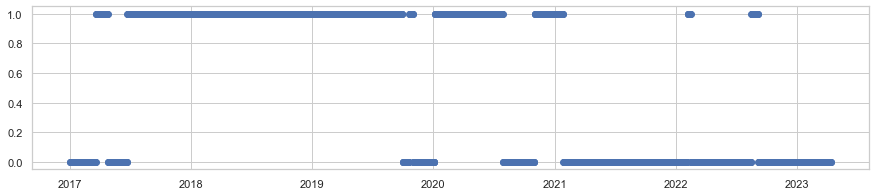

In [188]:
plt.figure(figsize=(15,3))
plt.scatter(d["index"], d["shortage_day"])
plt.show()